In [80]:
import abc
from abc import abstractmethod
from typing import Callable, Dict, Tuple, Optional, List
import itertools
import functools

import numpy as np
import scipy as sp
import einops
import quimb.tensor as qtn
import quimb.experimental.operatorbuilder as quimb_exp_op
from ml_collections import config_dict
import matplotlib.pyplot as plt

from tn_generative import *

# Physical Systems

- Modules for setting up physical systems

In [96]:
#@title || Define physical system.

class PhysicalSystem(abc.ABC):
  """Abstract class for defining physical systems."""

  @property
  def n_sites(self) -> int:
    """Returns number of sites."""
    return self._n_sites
  
  @abstractmethod
  def get_terms(self) -> List[Tuple[float, Tuple[str, int]]]:
    """Returns list of terms in the Hamiltonian."""
    return None

  @abstractmethod
  def get_ham_mpo(self) -> qtn.MatrixProductOperator:
    """Returns Hamiltonian MPO."""
    pass

  @abstractmethod
  def get_obs_mpos(self) -> List[qtn.MatrixProductOperator]:
    """Returns MPOs for observables."""
    pass

class SurfaceCode(PhysicalSystem):
  """Implementation for surface code.
    Note: this constructor assumes default ferromagnetic coupling. i.e.
    `coupling_value == 1` corresponds to `H = -1 * (Σ A) ...`. 
    Note: `get_terms` method in this constructor assumes +1 coupling. 
  """

  def __init__(self, 
      Lx: int, 
      Ly: int, 
      coupling_value: float = 1.0,
      onsite_z_field: float = 0.,
  ):
    self._n_sites = int(Lx * Ly)
    self.Lx = Lx
    self.Ly = Ly
    self.coupling_value = coupling_value
    self.onsite_z_field = onsite_z_field
    self.hilbert_space = quimb_exp_op.HilbertSpace(self.n_sites)
    
  def _get_surface_code_collections(self):
    """Constructs `NodeCollection`s for all terms in surface code Hamiltonian.
    """
    if self.Lx % 2 != 1 or self.Ly % 2 !=1:
      raise NotImplementedError('Only odd system sizes are implemented.')
    a1 = np.array([1.0, 0.0])  # unit vectors for square lattice.
    a2 = np.array([0.0, 1.0])
    unit_cell_points = np.stack([np.array([0, 0])])
    unit_cell = lattices.Lattice(unit_cell_points)

    lattice = sum(
        [unit_cell.shift(a1 * i + a2 * j)
        for i, j in itertools.product(range(self.Lx), range(self.Ly))]
    )
    # generating terms with Z plaquetts at the top left corner.
    z_top_loc = np.array((0, self.Ly - 1))
    z_base_plaquette = node_collections.build_path_from_sequence(
        lattice.get_idx(
            np.stack(  # specify plaquet going right, down, right and back up.
                [z_top_loc, z_top_loc + a1, z_top_loc + a1 - a2, z_top_loc - a2])
            ),
        lattice
    )
    # fixing boundary terms with x-x interactions 
    # for Z plaquetts on the boundary.
    x_top_boundary = node_collections.build_path_from_sequence(
        lattice.get_idx(np.stack([z_top_loc, z_top_loc + a1])), lattice
    )
    x_bot_boundary = x_top_boundary.shift(-a2 * (self.Ly - 1) + a1)

    # generating terms with X plaquetts at the second square 
    # from top left corner.
    x_top_loc = z_top_loc + a1
    x_base_plaquette = node_collections.build_path_from_sequence(
        lattice.get_idx(
            np.stack(
                [x_top_loc, x_top_loc + a1, x_top_loc + a1 - a2, x_top_loc - a2])
            ),
        lattice
    )
    # fixing boundary terms with z-z interactions for X plaquetts on the boundary.
    z_left_boundary = node_collections.build_path_from_sequence(
        lattice.get_idx(np.stack([z_top_loc - a2, z_top_loc - 2 * a2])), lattice
    )
    z_right_boundary = z_left_boundary.shift(a1 * (self.Lx - 1) + a2)

    n_shifts = max(self.Lx, self.Ly)
    z_plaquettes = node_collections.tile_on_lattice(
        z_base_plaquette, 2 * a1, a1 + a2, n_shifts
    )
    x_plaquettes = node_collections.tile_on_lattice(
        x_base_plaquette, 2 * a1, a1 + a2, n_shifts
    )
    x_boundaries = (
        node_collections.tile_on_lattice(
            x_top_boundary, 2 * a1, 0 * a2, n_shifts) +
        node_collections.tile_on_lattice(
            x_bot_boundary, 2 * a1, 0 * a2, n_shifts)
    )
    z_boundaries = (
        node_collections.tile_on_lattice(
            z_left_boundary, 0 * a1, 2 * a2, n_shifts) +
        node_collections.tile_on_lattice(
            z_right_boundary, 0 * a1, 2 * a2, n_shifts)
    )
    return z_plaquettes, x_plaquettes, z_boundaries, x_boundaries

  def get_terms(self,
  ) -> List[Tuple[float, Tuple[str, int]]]:
    """Generates all stabilizer terms in the surface code 
    from 4-plaquettes and 2-site boundaries.

    z_plaquettes: collection of 4-sites forming σz plaquettes.
    x_plaquettes: collection of 4-sites forming σx plaquettes.
    x_boundaries: collection of 2 boundary sites on Z plaquettes with x-x term.
    z_boundaries: collection of 2 boundary sites on X vertices with z-z term.

    Args:
      Lx: number of sites in x direction.
      Ly: number of sites in y direction.
      coupling_value: coupling coefficient.

    Returns:
      List of terms `z_plaquettes, x_plaquettes, z_boundaries, x_boundaries`
      representing the surface code hamiltonian.
    """
    z_plaquettes, x_plaquettes, z_boundaries, x_boundaries = (
        self._get_surface_code_collections()
    )
    # extract edges specified by lattice sites for each interaction term.
    z_plaquett_edges = node_collections.extract_edge_sequence(z_plaquettes)
    x_plaquett_edges = node_collections.extract_edge_sequence(x_plaquettes)
    xx_boundary_edges = node_collections.extract_edge_sequence(x_boundaries)
    zz_boundary_edges = node_collections.extract_edge_sequence(z_boundaries)
    # get sites for each interaction term by selecting sites.
    z_plaquett_sites = np.unique(
        einops.rearrange(z_plaquett_edges, 'b i s -> b (i s)'), axis=-1)
    x_plaquett_sites = np.unique(
        einops.rearrange(x_plaquett_edges, 'b i s -> b (i s)'), axis=-1)
    z_boundary_sites = np.unique(
        einops.rearrange(zz_boundary_edges, 'b i s -> b (i s)'), axis=-1)
    x_boundary_sites = np.unique(
        einops.rearrange(xx_boundary_edges, 'b i s -> b (i s)'), axis=-1)
    all_terms = []
    for i, j, k, l in z_plaquett_sites:
      terms = -self.coupling_value, ("z", i), ("z", j), ("z", k), ("z", l)
      all_terms.append(terms)
    for i, j, k, l in x_plaquett_sites:
      terms = -self.coupling_value, ("x", i), ("x", j), ("x", k), ("x", l)
      all_terms.append(terms)
    for i, j in z_boundary_sites:
      terms = -self.coupling_value, ("z", i), ("z", j)
      all_terms.append(terms)
    for i, j in x_boundary_sites:
      terms = -self.coupling_value, ("x", i), ("x", j)
      all_terms.append(terms)
    if self.onsite_z_field != 0.:  # add onsite fields if specified.
      for site in range(self.Lx * self.Ly):
        all_terms.append((-self.onsite_z_field, ("z", site)))
    return all_terms

  def _get_surface_code_hamiltonian_builder(self
  ) -> quimb_exp_op.SparseOperatorBuilder:
    """Generates surface code hamiltonian operator builder."""
    surface_code_H = quimb_exp_op.SparseOperatorBuilder(
        hilbert_space=self.hilbert_space
    )
    terms = self.get_terms()
    for term in terms:  # add all stabilizers to the hamiltonian.
      surface_code_H += term
    return surface_code_H
  
  def get_ham_mpo(self,
  ) -> qtn.MatrixProductOperator:
    """Get surface code hamiltonian as MPO."""
    surface_code_H = self._get_surface_code_hamiltonian_builder()
    return surface_code_H.build_mpo()

  def get_obs_mpos(self, 
      terms: Optional[List[Tuple[float, Tuple[str, int]]]] = None,
  ) ->  List[qtn.MatrixProductOperator]:
    """Get observables `terms` as MPOs.
    
    Args:
      terms: list of terms to include in the MPOs. Default (None) is to include
        all stabilizer terms in the surface code.
    
    Returns:
      List of MPOs.
    """
    hilbert_space = self.hilbert_space
    mpos = []
    if terms is None:
      # default: get all stabilizer terms in the surface code.
      terms = self.get_terms()
    for term in terms:
      _, *sites = term
      mpos.append(
          quimb_exp_op.SparseOperatorBuilder(
              [(1., *sites)], hilbert_space=hilbert_space).build_mpo()
      )
    return mpos

# Some quick examples

In [97]:
my_surface_code = SurfaceCode(Lx=3, Ly=3)

In [98]:
my_surface_code._get_surface_code_collections()

(NodesCollection(nodes=array([[2, 5, 5, 4, 4, 1, 1, 2],
        [4, 7, 7, 6, 6, 3, 3, 4]]), lattice=Lattice(points=array([[0., 0.],
        [0., 1.],
        [0., 2.],
        [1., 0.],
        [1., 1.],
        [1., 2.],
        [2., 0.],
        [2., 1.],
        [2., 2.]]), decimal_precision=3, n_sites=9, ndim=2), count=2, length=8),
 NodesCollection(nodes=array([[1, 4, 4, 3, 3, 0, 0, 1],
        [5, 8, 8, 7, 7, 4, 4, 5]]), lattice=Lattice(points=array([[0., 0.],
        [0., 1.],
        [0., 2.],
        [1., 0.],
        [1., 1.],
        [1., 2.],
        [2., 0.],
        [2., 1.],
        [2., 2.]]), decimal_precision=3, n_sites=9, ndim=2), count=2, length=8),
 NodesCollection(nodes=array([[1, 0, 0, 1],
        [8, 7, 7, 8]]), lattice=Lattice(points=array([[0., 0.],
        [0., 1.],
        [0., 2.],
        [1., 0.],
        [1., 1.],
        [1., 2.],
        [2., 0.],
        [2., 1.],
        [2., 2.]]), decimal_precision=3, n_sites=9, ndim=2), count=2, length=4),
 NodesC

In [99]:
my_surface_code.get_ham_mpo()

MatrixProductOperator(tensors=9, indices=26, L=9, max_bond=7)

In [100]:
my_surface_code.get_obs_mpos([(-0.5, ("z", 1)), (-0.5, ("x", 1))])

[MatrixProductOperator(tensors=9, indices=26, L=9, max_bond=2),
 MatrixProductOperator(tensors=9, indices=26, L=9, max_bond=2)]

# Integration with DMRG field scanning

In [101]:
TASK_REGISTRY = {}

DTYPES_REGISTRY = {
    'complex128': np.complex128,
    'complex64': np.complex64,
    'float64': np.float64,
    'float32': np.float32,
}

def _register_task(get_task_hamiltonian_fn, task_name: str):
  """Registers `get_task_hamiltonian_fn` in global `TASK_REGISTRY`."""
  registered_fn = TASK_REGISTRY.get(task_name, None)
  if registered_fn is None:
    TASK_REGISTRY[task_name] = get_task_hamiltonian_fn
  else:
    if registered_fn != get_task_hamiltonian_fn:
      raise ValueError(f'{task_name} is already registerd {registered_fn}.')

# def _register_ham(get_task_hamiltonian_fn: Callable[...], task_name: str):
#   """Registers `get_task_hamiltonian_fn` in global `TASK_REGISTRY`."""
#   registered_fn = TASK_REGISTRY.get(task_name, None)
#   if registered_fn is None:
#     TASK_REGISTRY[task_name] = get_task_hamiltonian_fn
#   else:
#     if registered_fn != get_task_hamiltonian_fn:
#       raise ValueError(f'{task_name} is already registerd {registered_fn}.')
    
register_task = lambda name: functools.partial(_register_task, task_name=name)

@register_task('surface_code')
def get_surface_code_mpo(
    size_x: int,
    size_y: int,
    coupling_value: float = 1.0,
    onsite_z_field: float = 0., 
):
  """Generates surface code MPO for `[size_x, size_y]` domain."""
  return SurfaceCode(size_x, size_y, coupling_value, onsite_z_field)

In [105]:
def surface_code_config(hz):
  config = config_dict.ConfigDict()
  # Task configuration.
  config.dtype = 'complex128'
  config.task = config_dict.ConfigDict()
  config.task.name = 'surface_code'
  config.task.kwargs = {'size_x': 3, 'size_y': 3, 'onsite_z_field':hz}
  # DMRG configuration.
  config.dmrg = config_dict.ConfigDict()
  config.dmrg.bond_dims = 20
  config.dmrg.solve_kwargs = {'max_sweeps': 40, 'cutoffs': 1e-6, 'verbosity': 1}
  # Sampler configuration.
  config.sampling = config_dict.ConfigDict()
  config.sampling.sampling_method = 'xz_basis_sampler'
  config.sampling.init_seed = 42
  config.sampling.num_samples = 50_000
  return config

stabilizers_field = []
onsite_z_field = []
mps_field = []
hz_fields = np.arange(0, 1., 0.05)
ED_energies = []
dmrg_energies = []
for hz in hz_fields:
  config = surface_code_config(hz)
  dtype = DTYPES_REGISTRY[config.dtype]
  task_system = TASK_REGISTRY[config.task.name](**config.task.kwargs)
  task_mpo = task_system.get_ham_mpo()
  qtn.contraction.set_tensor_linop_backend('numpy')
  qtn.contraction.set_contract_backend('numpy')
  mps = qtn.MPS_rand_state(task_mpo.L, config.dmrg.bond_dims, dtype=dtype)
  dmrg = qtn.DMRG1(task_mpo, bond_dims=config.dmrg.bond_dims, p0=mps)
  dmrg.solve(**config.dmrg.solve_kwargs)
  mps = dmrg.state.copy()
  mps = mps.canonize(0)  
  mps_field.append(mps)
  dmrg_energies.append(dmrg.energy)

  # ham_ed = qmb.experimental.operatorbuilder.get_mat(task_mpo)
  ham_ed = task_mpo.to_dense()
  eigval= sp.linalg.eigh(ham_ed, eigvals_only=True, 
                             subset_by_index=0)
  ED_energies.append(eigval[0])


  ## surface code specific testing.
  # Compute expectation values of the stabilizers.
  stabilizers = task_system.get_obs_mpos()
  stabilizers_expectation = [(mps.H @ (s.apply(mps))) for s in stabilizers]

  # compute the expectation value of onsite operators
  onsite_z_terms = [(-1., ("z", i)) for i in range(task_system.n_sites)]
  onsite_z_mpos = task_system.get_obs_mpos(onsite_z_terms)
  onsite_z_expectation = [(mps.H @ (s.apply(mps))) for s in onsite_z_mpos]
  stabilizers_field.append(stabilizers_expectation)
  onsite_z_field.append(onsite_z_expectation)

# return stabilizers_expectation, onsite_z_expectation


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


  0%|                                                     | 0/9 [00:00<?, ?it/s]

100%|#############################################| 9/9 [00:00<00:00, 77.99it/s]

Energy: (-7.999999999073879+3.885780586188048e-16j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 161.52it/s]

Energy: (-8.00000000000001+3.3306690738754696e-16j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 179.33it/s]

Energy: (-8.01437561376781-6.661338147750939e-16j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 126.35it/s]

Energy: (-8.014857293499592-2.220446049250313e-16j) ... not converged.
SWEEP-3, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 122.71it/s]

Energy: (-8.015383181116588+0j) ... not converged.
SWEEP-4, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 105.19it/s]

Energy: (-8.015387281590671+6.661338147750939e-16j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 187.98it/s]

Energy: (-8.065549658045082+2.220446049250313e-16j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|#############################################| 9/9 [00:00<00:00, 63.70it/s]

Energy: (-8.065549912127167+0j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 180.71it/s]

Energy: (-8.155769622342392+0j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 151.33it/s]

Energy: (-8.15577106156345+2.220446049250313e-16j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 191.80it/s]

Energy: (-8.289234258884997+0j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 145.50it/s]

Energy: (-8.289234627393654+2.7755575615628914e-16j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 184.80it/s]

Energy: (-8.466046318923471+0j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 172.14it/s]

Energy: (-8.466046540762603+3.3306690738754696e-16j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 183.50it/s]

Energy: (-8.68333976986973-2.220446049250313e-16j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 108.58it/s]

Energy: (-8.683340618066019+7.216449660063518e-16j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 150.16it/s]

Energy: (-8.936336020624234+3.3306690738754696e-16j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 148.08it/s]

Energy: (-8.93633618341758-3.885780586188048e-16j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 159.24it/s]

Energy: (-9.219604342688907+5.551115123125783e-17j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 155.78it/s]

Energy: (-9.219604592540273-1.1102230246251565e-16j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 185.62it/s]

Energy: (-9.527968286691616+0j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|#############################################| 9/9 [00:00<00:00, 68.62it/s]

Energy: (-9.527968446765101-1.6653345369377348e-16j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 177.60it/s]

Energy: (-9.85692633796015+4.996003610813204e-16j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 149.24it/s]

Energy: (-9.85692643648213-9.072603779358701e-16j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 116.27it/s]

Energy: (-10.20275174945955+3.9898639947466563e-17j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 170.96it/s]

Energy: (-10.202752022768593+4.371503159461554e-16j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 175.23it/s]

Energy: (-10.562433103550564+6.938893903907228e-16j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 168.27it/s]

Energy: (-10.562433291687812-8.604228440844963e-16j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 123.60it/s]

Energy: (-10.93355910246497+1.1102230246251565e-16j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 154.30it/s]

Energy: (-10.933559375800838+6.938893903907228e-16j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 182.57it/s]

Energy: (-11.314203359836231+2.7755575615628914e-17j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 160.97it/s]

Energy: (-11.314203526861228+1.942890293094024e-16j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 188.80it/s]

Energy: (-11.70282095773941-6.38378239159465e-16j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 175.21it/s]

Energy: (-11.70282136987561-4.484260185400046e-16j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 175.60it/s]

Energy: (-12.098168368333733-1.0755285551056204e-15j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|#############################################| 9/9 [00:00<00:00, 64.77it/s]

Energy: (-12.098168381550092-1.3183898417423734e-16j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 183.99it/s]

Energy: (-12.49923506906877-2.7755575615628914e-17j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 142.49it/s]

Energy: (-12.499235078971838+3.3306690738754696e-16j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 191.12it/s]

Energy: (-12.9051967994046+1.27675647831893e-15j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 147.82it/s]

Energy: (-12.905196823640136-1.942890293094024e-15j) ... converged!


SWEEP-1, direction=R, max_bond=(20/20), cutoff:1e-06


100%|############################################| 9/9 [00:00<00:00, 194.59it/s]

Energy: (-13.315375104960284+4.996003610813204e-16j) ... not converged.
SWEEP-2, direction=R, max_bond=(16/20), cutoff:1e-06



100%|############################################| 9/9 [00:00<00:00, 164.18it/s]

Energy: (-13.315375117560645+1.3010426069826053e-15j) ... converged!


In [106]:
overlaps = []
for i in range(len(hz_fields)-1):
  overlap = np.abs((mps_field[i+1].H @ mps_field[i]))**2
  overlaps.append(overlap)


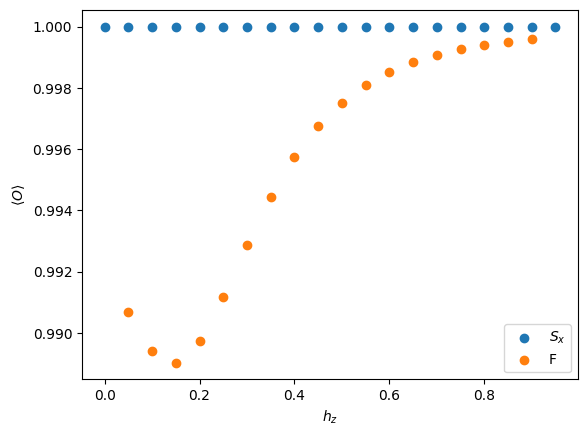

In [107]:
fig, ax = plt.subplots()
# ax.scatter(hz_fields, [onsite_z_field[i][0] for i in range(len(hz_fields))], label=r'$\sigma_z$')
ax.scatter(hz_fields, [np.real(stabilizers_field[i][0]) for i in range(len(hz_fields))], label=r'$S_x$')
ax.scatter(hz_fields[1:-1], overlaps[1:], label=r'F')
# ax.set_ylim(-1, 1)
ax.set_xlabel(r'$h_z$')
ax.set_ylabel(r'$\langle O \rangle$')
plt.legend()

# Regularization function

In [ ]:
#@title reguarlization function for surface code


def regularization_fn_surface_code(mps_model_arrays, train_ds, all_terms, hilbert_space):
  """Compute regularization contribution to the loss function."""
  mps_data_z = get_data_estimator_mps(train_ds, 'z')
  mps_data_x = get_data_estimator_mps(train_ds, 'x')
  est_expectations = estimate_exp_surface_code(
    all_terms, mps_data_z, mps_data_x, hilbert_space)
  mpos = [build_sparse_op([term], hilbert_space) for term in all_terms]
  mps_model = qmbt.MatrixProductState(arrays=mps_model_arrays)
  model_expectations = jnp.array([
    ((mps_model.H | mpo.apply(mps_model)) ^ ...)
    for mpo in mpos
  ])
  return jnp.sum(jnp.abs(est_expectations - model_expectations)**2)